Импортируемые библиотеки

In [ ]:
pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 597.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 68.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 70.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 6.0 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow import keras
import os
import zipfile
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

загрузка датасета

In [ ]:
df = pd.read_csv('Training_set.csv')

In [ ]:
df.head()

filename                     label
0  Image_1.jpg          SOUTHERN DOGFACE
1  Image_2.jpg                    ADONIS
2  Image_3.jpg            BROWN SIPROETA
3  Image_4.jpg                   MONARCH
4  Image_5.jpg  GREEN CELLED CATTLEHEART

In [ ]:
df.shape

(6499, 2)

создание тренировочной и тестовой выборки

In [ ]:
train_data, test_data = train_test_split(df, test_size=0.15)#, random_state=42)

задаём размер для всех изображений, по сколько изображений будет обрабатываться и кол-во эпох

In [ ]:
image_size = (200,200)
batch_size = 32
epochs = 40

создаём разные вариации изображений, чтобы модель была устойчивее к изменениям

In [ ]:
datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3,
    brightness_range=[0.7, 1.3],
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

In [ ]:
train_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory='/content/drive/MyDrive/train',
    x_col='filename',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    directory='/content/drive/MyDrive/train',
    x_col='filename',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
)

Found 5524 validated image filenames belonging to 75 classes.
Found 975 validated image filenames belonging to 75 classes.


отображение полученных изображений

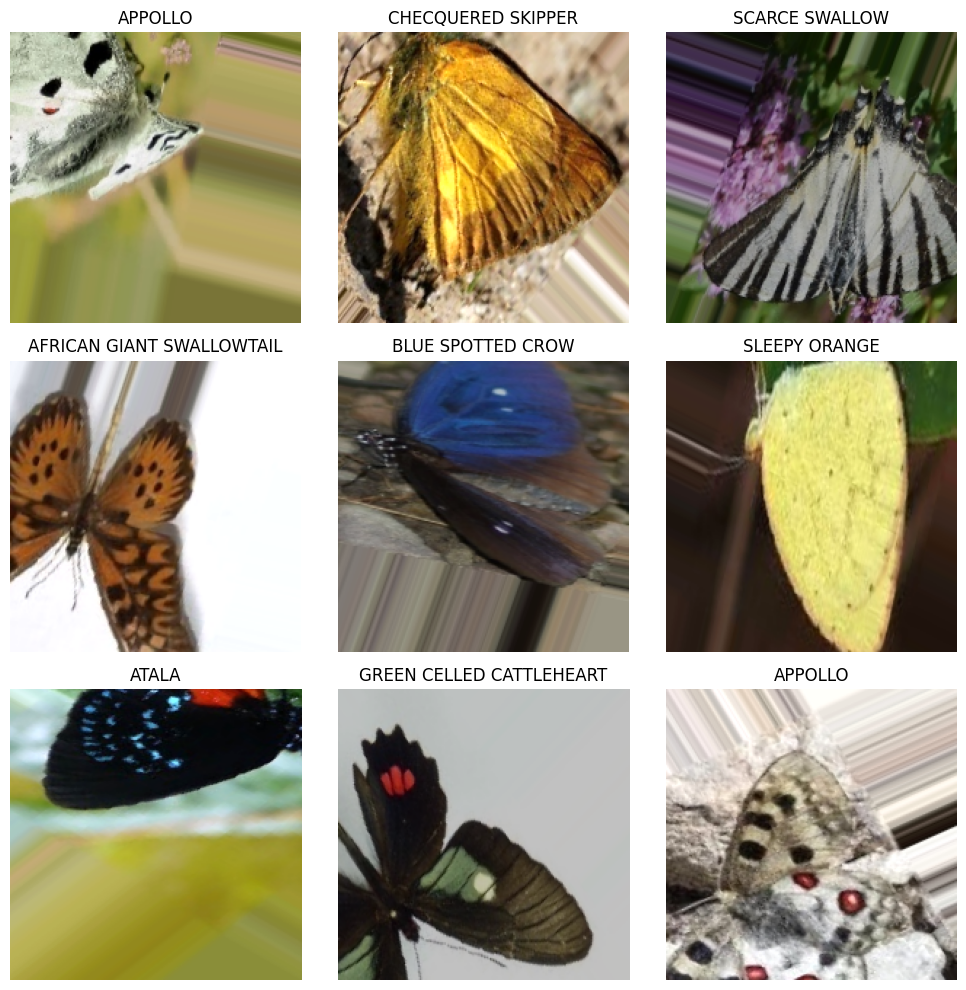

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

images, markers = next(train_generator) # получаем из генератора изображения и метки к ним

class_names = {v: k for k, v in train_generator.class_indices.items()} # переворачивает словарь

plt.figure(figsize=(10, 10)) # выводим 9 картинок на экран
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    label_index = np.argmax(markers[i])
    label_name = class_names[label_index]
    plt.title(f"{label_name}")
    plt.axis('off')

plt.tight_layout()
plt.show()

нейронная модель, 5 свёрточных слоя, 1 полносвязный слой

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(200,200,3)),

    # Блок 1
    tf.keras.layers.Conv2D(128, (3,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),

    # Блок 2
    tf.keras.layers.Conv2D(256, (3,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # Блок 3
    tf.keras.layers.Conv2D(512, (3,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # Блок 4
    tf.keras.layers.Conv2D(512, (3,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # Блок 5
    tf.keras.layers.Conv2D(1024, (3,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # Полносвязная часть
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation='swish'),
    tf.keras.layers.Dropout(0.3),

    # Выход
    tf.keras.layers.Dense(df['label'].nunique(), activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 198, 198, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 198, 198, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 198, 198, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 99, 99, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 99, 99, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 97, 97, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 97, 97, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 97, 97, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 48, 48, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 46, 46, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 46, 46, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 46, 46, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 23, 23, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 21, 21, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 21, 21, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 21, 21, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 10, 10, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 1024)     │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 8, 8, 1024)     │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 8, 8, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 4, 4, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │             

 Total params: 9,694,539 (36.98 MB)

 Trainable params: 9,689,675 (36.96 MB)

 Non-trainable params: 4,864 (19.00 KB)

In [ ]:
pip install visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.4/997.4 kB 15.2 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


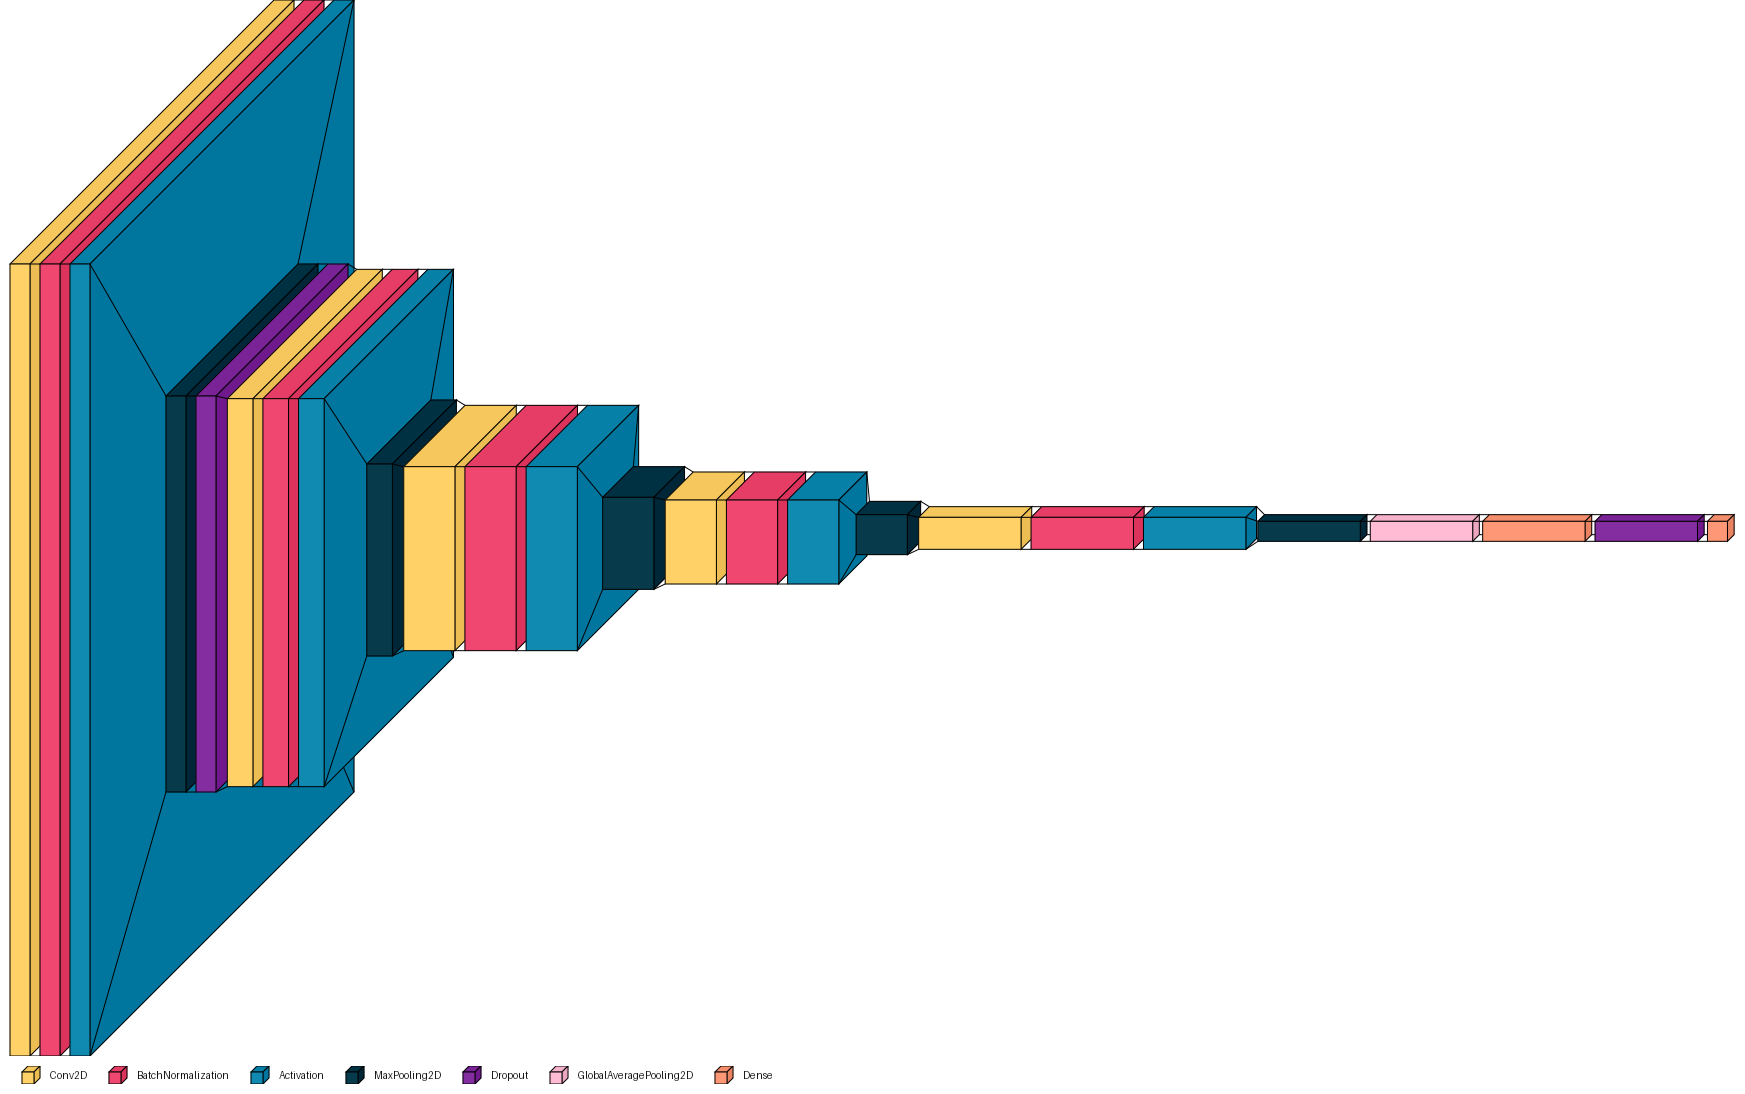

In [ ]:
import visualkeras
from PIL import ImageFont
visualkeras.layered_view(model, legend=True)

настраиваем процесс обучения модели

In [ ]:
optimizer = tf.keras.optimizers.AdamW(learning_rate=0.001, weight_decay=0.0001)
loss = 'categorical_crossentropy'
metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]

model.compile(
      optimizer=optimizer,
      loss=loss,
      metrics=metrics
  )

добавим раннюю остановку в обучении, а также чекпоинты, для сохранения лучше версии модели

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_auc',
        patience=15,
        restore_best_weights=True,
        mode='max'),

    tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True),

    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_auc',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        mode='max')
]

from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced',
                                   classes=np.unique(train_generator.classes),
                                   y=train_generator.classes)
class_weight = dict(enumerate(class_weights))

обучаем модель

In [ ]:
history = model.fit(
          train_generator,
          validation_data=test_generator,
          epochs=65,
          steps_per_epoch=len(train_generator),
          validation_steps=len(test_generator),
          callbacks=callbacks,
          class_weight=class_weight)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/65
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.0515 - auc: 0.6509 - loss: 4.3567 

173/173 ━━━━━━━━━━━━━━━━━━━━ 2097s 12s/step - accuracy: 0.0516 - auc: 0.6513 - loss: 4.3546 - val_accuracy: 0.0297 - val_auc: 0.5431 - val_loss: 4.6144 - learning_rate: 0.0010
Epoch 2/65
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.1233 - auc: 0.8266 - loss: 3.5140

173/173 ━━━━━━━━━━━━━━━━━━━━ 124s 546ms/step - accuracy: 0.1233 - auc: 0.8266 - loss: 3.5135 - val_accuracy: 0.0687 - val_auc: 0.6512 - val_loss: 4.5479 - learning_rate: 0.0010
Epoch 3/65
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.1717 - auc: 0.8687 - loss: 3.1716

173/173 ━━━━━━━━━━━━━━━━━━━━ 142s 549ms/step - accuracy: 0.1718 - auc: 0.8688 - loss: 3.1711 - val_accuracy: 0.1610 - val_auc: 0.8774 - val_loss: 3.1513 - learning_rate: 0.0010
Epoch 4/65
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.2477 - auc: 0.9089 - loss: 2.7691

173/173 ━━━━━━━━━━━━━━━━━━━━ 141s 542ms/step - accuracy: 0.2477 - auc: 0.9089 - loss: 2.7690 - val_accuracy: 0.3436 - val_auc: 0.9264 - val_loss: 2.4006 - learning_rate: 0.0010
Epoch 5/65
173/173 ━━━━━━━━━━━━━━━━━━━━ 141s 535ms/step - accuracy: 0.2989 - auc: 0.9211 - loss: 2.5745 - val_accuracy: 0.1867 - val_auc: 0.8247 - val_loss: 3.7129 - learning_rate: 0.0010
Epoch 6/65
173/173 ━━━━━━━━━━━━━━━━━━━━ 92s 533ms/step - accuracy: 0.3418 - auc: 0.9342 - loss: 2.3621 - val_accuracy: 0.2944 - val_auc: 0.9020 - val_loss: 2.6950 - learning_rate: 0.0010
Epoch 7/65
173/173 ━━━━━━━━━━━━━━━━━━━━ 93s 534ms/step - accuracy: 0.3615 - auc: 0.9364 - loss: 2.2819 - val_accuracy: 0.3590 - val_auc: 0.9151 - val_loss: 2.4231 - learning_rate: 0.0010
Epoch 8/65
173/173 ━━━━━━━━━━━━━━━━━━━━ 93s 536ms/step - accuracy: 0.3868 - auc: 0.9443 - loss: 2.1596 - val_accuracy: 0.2544 - val_auc: 0.8500 - val_loss: 3.3085 - learning_rate: 0.0010
Epoch 9/65
173/173 ━━━━━━━━━━━━━━━━━━━━ 144s 546ms/step - accuracy: 0.4237

173/173 ━━━━━━━━━━━━━━━━━━━━ 141s 543ms/step - accuracy: 0.4801 - auc: 0.9615 - loss: 1.8093 - val_accuracy: 0.5641 - val_auc: 0.9675 - val_loss: 1.5023 - learning_rate: 5.0000e-04
Epoch 11/65
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - accuracy: 0.5187 - auc: 0.9681 - loss: 1.6127

173/173 ━━━━━━━━━━━━━━━━━━━━ 94s 544ms/step - accuracy: 0.5187 - auc: 0.9681 - loss: 1.6128 - val_accuracy: 0.5672 - val_auc: 0.9663 - val_loss: 1.4680 - learning_rate: 5.0000e-04
Epoch 12/65
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - accuracy: 0.5099 - auc: 0.9660 - loss: 1.6540

173/173 ━━━━━━━━━━━━━━━━━━━━ 142s 542ms/step - accuracy: 0.5099 - auc: 0.9660 - loss: 1.6538 - val_accuracy: 0.5662 - val_auc: 0.9702 - val_loss: 1.4304 - learning_rate: 5.0000e-04
Epoch 13/65
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.5490 - auc: 0.9702 - loss: 1.5584

173/173 ━━━━━━━━━━━━━━━━━━━━ 143s 546ms/step - accuracy: 0.5490 - auc: 0.9702 - loss: 1.5583 - val_accuracy: 0.6051 - val_auc: 0.9667 - val_loss: 1.4204 - learning_rate: 5.0000e-04
Epoch 14/65
173/173 ━━━━━━━━━━━━━━━━━━━━ 94s 545ms/step - accuracy: 0.5574 - auc: 0.9720 - loss: 1.4957 - val_accuracy: 0.4492 - val_auc: 0.9302 - val_loss: 2.0831 - learning_rate: 5.0000e-04
Epoch 15/65
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.5716 - auc: 0.9726 - loss: 1.4666

173/173 ━━━━━━━━━━━━━━━━━━━━ 141s 537ms/step - accuracy: 0.5716 - auc: 0.9726 - loss: 1.4666 - val_accuracy: 0.6041 - val_auc: 0.9758 - val_loss: 1.3092 - learning_rate: 5.0000e-04
Epoch 16/65
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - accuracy: 0.5842 - auc: 0.9741 - loss: 1.4053

173/173 ━━━━━━━━━━━━━━━━━━━━ 142s 538ms/step - accuracy: 0.5842 - auc: 0.9741 - loss: 1.4053 - val_accuracy: 0.6749 - val_auc: 0.9783 - val_loss: 1.0582 - learning_rate: 5.0000e-04
Epoch 17/65
173/173 ━━━━━━━━━━━━━━━━━━━━ 93s 534ms/step - accuracy: 0.6060 - auc: 0.9754 - loss: 1.3581 - val_accuracy: 0.6215 - val_auc: 0.9713 - val_loss: 1.3242 - learning_rate: 5.0000e-04
Epoch 18/65
173/173 ━━━━━━━━━━━━━━━━━━━━ 94s 543ms/step - accuracy: 0.5997 - auc: 0.9774 - loss: 1.3276 - val_accuracy: 0.5610 - val_auc: 0.9504 - val_loss: 1.6664 - learning_rate: 5.0000e-04
Epoch 19/65
173/173 ━━━━━━━━━━━━━━━━━━━━ 140s 532ms/step - accuracy: 0.6277 - auc: 0.9781 - loss: 1.2806 - val_accuracy: 0.6462 - val_auc: 0.9681 - val_loss: 1.2621 - learning_rate: 5.0000e-04
Epoch 20/65
173/173 ━━━━━━━━━━━━━━━━━━━━ 143s 541ms/step - accuracy: 0.6369 - auc: 0.9789 - loss: 1.2298 - val_accuracy: 0.6964 - val_auc: 0.9777 - val_loss: 1.0735 - learning_rate: 5.0000e-04
Epoch 21/65
173/173 ━━━━━━━━━━━━━━━━━━━━ 93s 539m

173/173 ━━━━━━━━━━━━━━━━━━━━ 143s 542ms/step - accuracy: 0.6766 - auc: 0.9832 - loss: 1.1001 - val_accuracy: 0.7200 - val_auc: 0.9828 - val_loss: 0.9335 - learning_rate: 2.5000e-04
Epoch 23/65
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.6817 - auc: 0.9823 - loss: 1.0785

173/173 ━━━━━━━━━━━━━━━━━━━━ 141s 535ms/step - accuracy: 0.6817 - auc: 0.9823 - loss: 1.0784 - val_accuracy: 0.7528 - val_auc: 0.9834 - val_loss: 0.8757 - learning_rate: 2.5000e-04
Epoch 24/65
173/173 ━━━━━━━━━━━━━━━━━━━━ 143s 540ms/step - accuracy: 0.7075 - auc: 0.9860 - loss: 1.0046 - val_accuracy: 0.7415 - val_auc: 0.9811 - val_loss: 0.9444 - learning_rate: 2.5000e-04
Epoch 25/65
173/173 ━━━━━━━━━━━━━━━━━━━━ 140s 530ms/step - accuracy: 0.7012 - auc: 0.9849 - loss: 0.9885 - val_accuracy: 0.7292 - val_auc: 0.9815 - val_loss: 0.9206 - learning_rate: 2.5000e-04
Epoch 26/65
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.7162 - auc: 0.9887 - loss: 0.9267

173/173 ━━━━━━━━━━━━━━━━━━━━ 94s 543ms/step - accuracy: 0.7162 - auc: 0.9887 - loss: 0.9269 - val_accuracy: 0.7641 - val_auc: 0.9845 - val_loss: 0.8168 - learning_rate: 2.5000e-04
Epoch 27/65
173/173 ━━━━━━━━━━━━━━━━━━━━ 139s 529ms/step - accuracy: 0.7100 - auc: 0.9867 - loss: 0.9544 - val_accuracy: 0.7292 - val_auc: 0.9817 - val_loss: 0.9128 - learning_rate: 2.5000e-04
Epoch 28/65
173/173 ━━━━━━━━━━━━━━━━━━━━ 144s 541ms/step - accuracy: 0.7117 - auc: 0.9874 - loss: 0.9583 - val_accuracy: 0.7467 - val_auc: 0.9833 - val_loss: 0.8347 - learning_rate: 2.5000e-04
Epoch 29/65
173/173 ━━━━━━━━━━━━━━━━━━━━ 93s 535ms/step - accuracy: 0.7306 - auc: 0.9886 - loss: 0.8939 - val_accuracy: 0.7149 - val_auc: 0.9804 - val_loss: 0.9597 - learning_rate: 2.5000e-04
Epoch 30/65
173/173 ━━━━━━━━━━━━━━━━━━━━ 93s 538ms/step - accuracy: 0.7149 - auc: 0.9875 - loss: 0.9310 - val_accuracy: 0.7569 - val_auc: 0.9797 - val_loss: 0.8808 - learning_rate: 2.5000e-04
Epoch 31/65
173/173 ━━━━━━━━━━━━━━━━━━━━ 140s 529m

173/173 ━━━━━━━━━━━━━━━━━━━━ 142s 531ms/step - accuracy: 0.7556 - auc: 0.9908 - loss: 0.8083 - val_accuracy: 0.7877 - val_auc: 0.9862 - val_loss: 0.7585 - learning_rate: 1.2500e-04
Epoch 34/65
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.7588 - auc: 0.9912 - loss: 0.7735

173/173 ━━━━━━━━━━━━━━━━━━━━ 142s 535ms/step - accuracy: 0.7589 - auc: 0.9912 - loss: 0.7735 - val_accuracy: 0.8041 - val_auc: 0.9857 - val_loss: 0.6859 - learning_rate: 1.2500e-04
Epoch 35/65
173/173 ━━━━━━━━━━━━━━━━━━━━ 93s 534ms/step - accuracy: 0.7588 - auc: 0.9901 - loss: 0.7922 - val_accuracy: 0.7826 - val_auc: 0.9860 - val_loss: 0.7751 - learning_rate: 1.2500e-04
Epoch 36/65
173/173 ━━━━━━━━━━━━━━━━━━━━ 142s 534ms/step - accuracy: 0.7631 - auc: 0.9905 - loss: 0.7791 - val_accuracy: 0.7877 - val_auc: 0.9876 - val_loss: 0.7163 - learning_rate: 1.2500e-04
Epoch 37/65
173/173 ━━━━━━━━━━━━━━━━━━━━ 141s 532ms/step - accuracy: 0.7738 - auc: 0.9911 - loss: 0.7516 - val_accuracy: 0.7836 - val_auc: 0.9828 - val_loss: 0.7484 - learning_rate: 1.2500e-04
Epoch 38/65
173/173 ━━━━━━━━━━━━━━━━━━━━ 93s 537ms/step - accuracy: 0.7792 - auc: 0.9925 - loss: 0.7366 - val_accuracy: 0.7990 - val_auc: 0.9841 - val_loss: 0.7257 - learning_rate: 1.2500e-04
Epoch 39/65
173/173 ━━━━━━━━━━━━━━━━━━━━ 140s 529

173/173 ━━━━━━━━━━━━━━━━━━━━ 101s 580ms/step - accuracy: 0.7747 - auc: 0.9911 - loss: 0.7393 - val_accuracy: 0.8113 - val_auc: 0.9853 - val_loss: 0.6845 - learning_rate: 1.2500e-04
Epoch 42/65
173/173 ━━━━━━━━━━━━━━━━━━━━ 99s 574ms/step - accuracy: 0.7788 - auc: 0.9948 - loss: 0.6906 - val_accuracy: 0.8051 - val_auc: 0.9857 - val_loss: 0.6985 - learning_rate: 6.2500e-05
Epoch 43/65
173/173 ━━━━━━━━━━━━━━━━━━━━ 141s 570ms/step - accuracy: 0.7978 - auc: 0.9931 - loss: 0.6710 - val_accuracy: 0.8082 - val_auc: 0.9838 - val_loss: 0.7077 - learning_rate: 6.2500e-05
Epoch 44/65
173/173 ━━━━━━━━━━━━━━━━━━━━ 100s 579ms/step - accuracy: 0.7982 - auc: 0.9921 - loss: 0.6630 - val_accuracy: 0.8051 - val_auc: 0.9873 - val_loss: 0.6873 - learning_rate: 6.2500e-05
Epoch 45/65
173/173 ━━━━━━━━━━━━━━━━━━━━ 139s 562ms/step - accuracy: 0.7915 - auc: 0.9930 - loss: 0.6727 - val_accuracy: 0.8021 - val_auc: 0.9849 - val_loss: 0.6882 - learning_rate: 6.2500e-05
Epoch 46/65
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 532m

173/173 ━━━━━━━━━━━━━━━━━━━━ 141s 555ms/step - accuracy: 0.7903 - auc: 0.9917 - loss: 0.6834 - val_accuracy: 0.8226 - val_auc: 0.9861 - val_loss: 0.6539 - learning_rate: 6.2500e-05
Epoch 47/65
173/173 ━━━━━━━━━━━━━━━━━━━━ 143s 562ms/step - accuracy: 0.8034 - auc: 0.9946 - loss: 0.6359 - val_accuracy: 0.8226 - val_auc: 0.9861 - val_loss: 0.6582 - learning_rate: 3.1250e-05
Epoch 48/65
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - accuracy: 0.8080 - auc: 0.9951 - loss: 0.6131

173/173 ━━━━━━━━━━━━━━━━━━━━ 145s 578ms/step - accuracy: 0.8080 - auc: 0.9951 - loss: 0.6132 - val_accuracy: 0.8277 - val_auc: 0.9866 - val_loss: 0.6459 - learning_rate: 3.1250e-05
Epoch 49/65
173/173 ━━━━━━━━━━━━━━━━━━━━ 139s 559ms/step - accuracy: 0.8018 - auc: 0.9924 - loss: 0.6434 - val_accuracy: 0.8174 - val_auc: 0.9860 - val_loss: 0.6728 - learning_rate: 3.1250e-05
Epoch 50/65
173/173 ━━━━━━━━━━━━━━━━━━━━ 140s 545ms/step - accuracy: 0.8043 - auc: 0.9930 - loss: 0.6439 - val_accuracy: 0.8154 - val_auc: 0.9865 - val_loss: 0.6839 - learning_rate: 3.1250e-05
Epoch 51/65
173/173 ━━━━━━━━━━━━━━━━━━━━ 94s 544ms/step - accuracy: 0.7981 - auc: 0.9935 - loss: 0.6371 - val_accuracy: 0.8205 - val_auc: 0.9855 - val_loss: 0.6678 - learning_rate: 3.1250e-05


первая версия модели с 200к параметров обучилась только на 50%
вторая версия модели с 560к параметров обучилась accuracy: 0.7145 - val_accuracy: 0.6492
третья версия модели с 2,150к параметров обучилась accuracy: 0.7855 - val_accuracy: 0.7415
четвёртая версия модели с 2,750к параметров обучилась accuracy: 0.8213 - val_accuracy: 0.7731
пятая версия модели с 2,750к параметров обучилась accuracy: 0.8158 - auc: 0.9951 - val_accuracy: 0.8138
 шестая версия модели с 4,5кк параметров обучилась accuracy: 0.8880 - auc: 0.9966 - val_accuracy: 0.8323(63 эпохи)
 последняя седьмая версия с 9,7кк параметров обучилась на 85% train and val

построим графики чтобы отследить точность на каждой эпохе, а также проанализируем нашу модель

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

NameError: name 'plt' is not defined

In [ ]:
import os
print(f"Размер файла: {os.path.getsize('best_model.h5') / (1024*1024):.2f} MB")

Размер файла: 111.02 MB


In [ ]:
best_model = tf.keras.models.load_model('best_model.h5')

In [ ]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 198, 198, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 198, 198, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 198, 198, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 99, 99, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 99, 99, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 97, 97, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 97, 97, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 97, 97, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 48, 48, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 46, 46, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 46, 46, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 46, 46, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 23, 23, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 21, 21, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 21, 21, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 21, 21, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 1024)     │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 1024)     │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 8, 8, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │             

 Total params: 9,694,541 (36.98 MB)

 Trainable params: 9,689,675 (36.96 MB)

 Non-trainable params: 4,864 (19.00 KB)

 Optimizer params: 2 (12.00 B)

In [ ]:
test_df = pd.read_csv('Testing_set.csv')

In [ ]:
test_df.head()

filename
0  Image_1.jpg
1  Image_2.jpg
2  Image_3.jpg
3  Image_4.jpg
4  Image_5.jpg

In [ ]:
test_datagen_2 = ImageDataGenerator(rescale=1./255)

test_generator_2 = test_datagen_2.flow_from_dataframe(
    dataframe=test_df,
    directory='/content/drive/MyDrive/test',
    x_col='filename',
    y_col=None,       # указываем, что меток нет
    target_size=(200, 200),
    batch_size=32,
    class_mode=None,  # только изображения, без меток
    shuffle=False      # сохраняем порядок файлов
)

Found 2786 validated image filenames.


In [ ]:
predictions = best_model.predict(
    test_generator_2,
    steps=len(test_generator_2),
    verbose=1
)

# Преобразование one-hot в номера классов
predicted_classes = np.argmax(predictions, axis=1)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


88/88 ━━━━━━━━━━━━━━━━━━━━ 17s 190ms/step


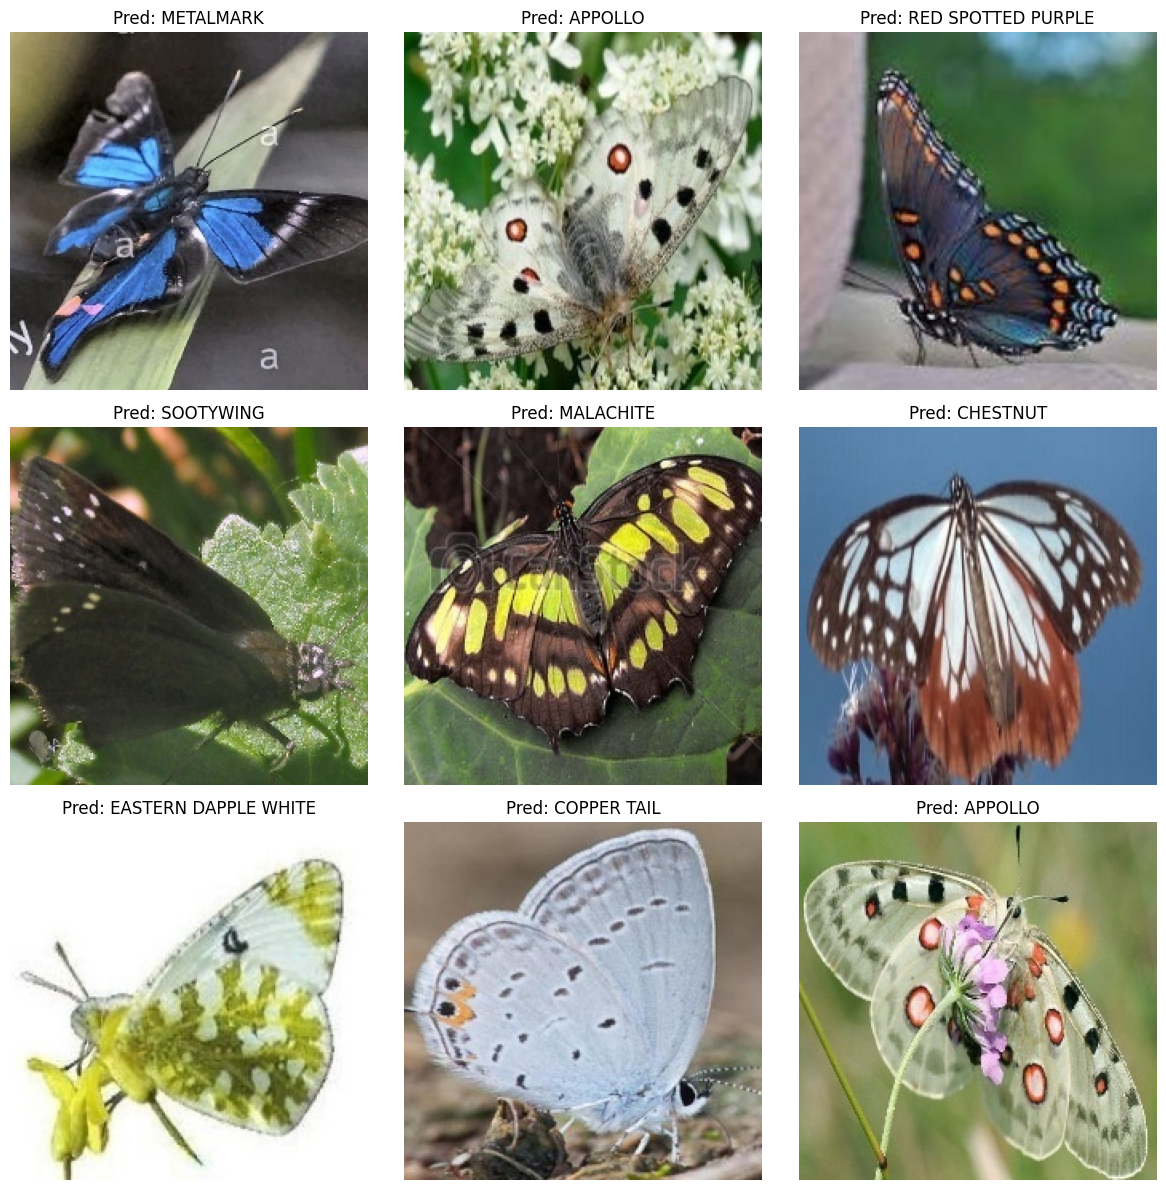

In [ ]:
import matplotlib.pyplot as plt
import os

# Получаем имена классов из тренировочного генератора
class_names = list(train_generator.class_indices.keys())  # Предполагая, что train_generator был создан с метками

# Выбираем случайные 9 изображений для отображения
indices = np.random.choice(len(test_df), 9, replace=False)

plt.figure(figsize=(12, 12))
for i, idx in enumerate(indices):
    plt.subplot(3, 3, i+1)
    img_path = os.path.join('/content/drive/MyDrive/test', test_df.iloc[idx]['filename'])
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.title(f"Pred: {class_names[predicted_classes[idx]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    directory='/content/drive/MyDrive/train',
    x_col='filename',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 975 validated image filenames belonging to 75 classes.


In [ ]:
# Сброс генератора
test_generator.reset()

predictions_2 = best_model.predict(
    test_generator,
    steps=len(test_generator),
    verbose=1
)

# Преобразование one-hot в номера классов
predicted_classes_2 = np.argmax(predictions_2, axis=1)

true_classes_2 = test_generator.classes
class_names_2 = list(test_generator.class_indices.keys())

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step


                           precision    recall  f1-score   support

                   ADONIS       1.00      1.00      1.00         8
AFRICAN GIANT SWALLOWTAIL       1.00      0.94      0.97        16
           AMERICAN SNOOT       0.70      1.00      0.82         7
                    AN 88       1.00      1.00      1.00         8
                  APPOLLO       1.00      0.94      0.97        17
                    ATALA       0.92      1.00      0.96        11
 BANDED ORANGE HELICONIAN       0.93      0.93      0.93        14
           BANDED PEACOCK       0.55      0.86      0.67        14
            BECKERS WHITE       0.89      1.00      0.94        16
         BLACK HAIRSTREAK       0.79      1.00      0.88        15
              BLUE MORPHO       0.82      0.69      0.75        13
        BLUE SPOTTED CROW       0.75      1.00      0.86         6
           BROWN SIPROETA       0.90      1.00      0.95        19
            CABBAGE WHITE       0.78      0.93      0.85     

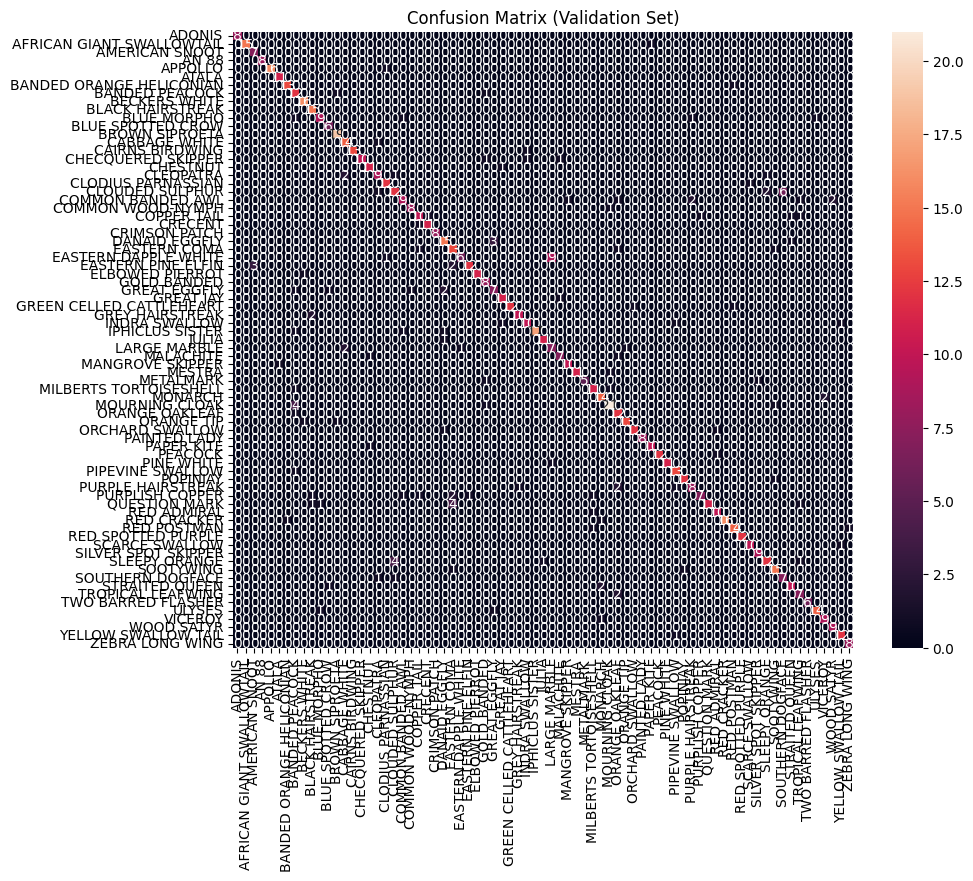

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(
    true_classes_2,
    predicted_classes_2,
    target_names=class_names_2
))
import seaborn as sns
# Матрица ошибок
plt.figure(figsize=(10,8))
sns.heatmap(
    confusion_matrix(true_classes_2, predicted_classes_2),
    annot=True,
    fmt='d',
    xticklabels=class_names_2,
    yticklabels=class_names_2
)
plt.title('Confusion Matrix (Validation Set)')
plt.show()